In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
!pip install rasterio
!pip install matplotlib
!pip install pandas
!pip install streamlit
!pip install pyngrok

In [ ]:
import rasterio
import pandas as pd
import numpy as np
import os

# Function to read and store band data for each folder path (year-wise)
def read_bands(folder_paths, bands):
    band_arrays = {}
    for year, folder_path in folder_paths.items():
        for band in bands:
            band_files = [
                os.path.join(folder_path, f"{year}-{band}_{month}.jpg")
                for month in ['Jan', 'Feb', 'Mar', 'April', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
            ]

            for file in band_files:
                with rasterio.open(file) as src:
                    # Extract month and band name (e.g., 2020-B8A_Jan)
                    file_name = file.split("/")[-1].split(".")[0]
                    band_arrays[file_name] = src.read(1)
                    print(f"Extracted file name: {file_name}")
                    print(f"Data shape for {file_name}: {band_arrays[file_name].shape}")

    return band_arrays

# Folder paths for each index, each year separately from 2020 to 2024
folders = {
    'NDVI': {
        '2020': "/content/drive/MyDrive/dataset/NDVI_2020",
        '2021': "/content/drive/MyDrive/dataset/NDVI_2021",
        '2022': "/content/drive/MyDrive/dataset/NDVI_2022",
        '2023': "/content/drive/MyDrive/dataset/NDVI_2023",
        '2024': "/content/drive/MyDrive/dataset/NDVI_2024"
    },
    'MI': {
        '2020': "/content/drive/MyDrive/dataset/MI_2020",
        '2021': "/content/drive/MyDrive/dataset/MI_2021",
        '2022': "/content/drive/MyDrive/dataset/MI_2022",
        '2023': "/content/drive/MyDrive/dataset/MI_2023",
        '2024': "/content/drive/MyDrive/dataset/MI_2024"
    },
    'SAVI': {
        '2020': "/content/drive/MyDrive/dataset/SAVI_2020",
        '2021': "/content/drive/MyDrive/dataset/SAVI_2021",
        '2022': "/content/drive/MyDrive/dataset/SAVI_2022",
        '2023': "/content/drive/MyDrive/dataset/SAVI_2023",
        '2024': "/content/drive/MyDrive/dataset/SAVI_2024"
    },
    'NDBI': {
        '2020': "/content/drive/MyDrive/dataset/NDBI_2020",
        '2021': "/content/drive/MyDrive/dataset/NDBI_2021",
        '2022': "/content/drive/MyDrive/dataset/NDBI_2022",
        '2023': "/content/drive/MyDrive/dataset/NDBI_2023",
        '2024': "/content/drive/MyDrive/dataset/NDBI_2024"
    },
    'EVI': {
        '2020': "/content/drive/MyDrive/dataset/EVI_2020",
        '2021': "/content/drive/MyDrive/dataset/EVI_2021",
        '2022': "/content/drive/MyDrive/dataset/EVI_2022",
        '2023': "/content/drive/MyDrive/dataset/EVI_2023",
        '2024': "/content/drive/MyDrive/dataset/EVI_2024"
    },
    'NDWI': {
        '2020': "/content/drive/MyDrive/dataset/NDWI_2020",
        '2021': "/content/drive/MyDrive/dataset/NDWI_2021",
        '2022': "/content/drive/MyDrive/dataset/NDWI_2022",
        '2023': "/content/drive/MyDrive/dataset/NDWI_2023",
        '2024': "/content/drive/MyDrive/dataset/NDWI_2024"
    }
}

# Band configurations for each index
bands_config = {
    'NDVI': ['B08', 'B04'],  #for NDVI (Normalized Difference Vegetation Index)
    'MI': ['B8A', 'B11'],    #for MI (Moisture Index)
    'SAVI': ['B08', 'B04'],  #for SAVI (Soil-Adjusted Vegetation Index)
    'NDBI': ['B11', 'B08'],  #for NDBI (Normalized Difference Built-up Index)
    'EVI': ['B08', 'B04', 'B02'], #for EVI (Enhanced Vegetation Index)
    'NDWI': ['B03', 'B08']   #for NDWI (Normalized Difference Water Index)
}

# Read band data for each index for each year
band_arrays_dict = {}
for index, folder_paths in folders.items():
    band_arrays_dict[index] = read_bands(folder_paths, bands_config[index])

# Function to calculate index values and save them
def calculate_and_save_indices(index_name, band_arrays, formula):
    index_scores = {}

    # Loop through each year and month to calculate the index
    for year in sorted(set(band_name.split('-')[0] for band_name in band_arrays.keys())):
        for month in ['Jan', 'Feb', 'Mar', 'April', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']:
            # Create the key names for each band
            band_keys = [f"{year}-{band}_{month}" for band in bands_config[index_name]]
            if all(band_key in band_arrays for band_key in band_keys):
                # Extract the bands
                band_data = [band_arrays[band_key] for band_key in band_keys]

                # Apply the formula for the index
                index = formula(*band_data)

                # Clip and clean the index values
                index = np.clip(index, -1, 1)
                index = np.nan_to_num(index, nan=0.0)

                # Compute the mean index score
                mean_score = np.mean(index)
                index_scores[f"{year}_{month}"] = mean_score

                print(f"Mean {index_name} Score for {year} {month}: {mean_score}")
            else:
                print(f"Missing bands for {year} {month} for {index_name}: {band_keys}")

    return index_scores


# Define the formulas for each index
def calculate_ndvi(B8, B4):
    return (B8 - B4) / (B8 + B4)

def calculate_moisture_index(B8A, B11):
    return (B8A - B11) / (B8A + B11)

def calculate_savi(B8, B4, L=0.5):
    return ((B8 - B4) / (B8 + B4 + L)) * (1 + L)

def calculate_ndbi(B11, B8):
    return (B11 - B8) / (B11 + B8)

def calculate_evi(B8, B4, B2):
    return 2.5 * ((B8 - B4) / (B8 + 6.0 * B4 - 7.5 * B2 + 1))

def calculate_ndwi(B3, B8):
    return (B3 - B8) / (B3 + B8)


# Calculate and combine all indices into one dataframe
index_scores_dict = {}
for index, formula in zip(['NDVI', 'MI', 'SAVI', 'NDBI', 'EVI', 'NDWI'],
                          [calculate_ndvi, calculate_moisture_index, calculate_savi, calculate_ndbi, calculate_evi, calculate_ndwi]):
    index_scores = calculate_and_save_indices(index, band_arrays_dict[index], formula)
    index_scores_dict[index] = index_scores

# Create the final dataframe by merging all the index scores
final_df = pd.DataFrame({'Year_Month': list(index_scores_dict['NDVI'].keys())})
for index, index_scores in index_scores_dict.items():
    index_scores_df = pd.DataFrame(list(index_scores.items()), columns=['Year_Month', f'Mean_{index}_Score'])
    final_df = final_df.merge(index_scores_df, on='Year_Month')

# Save the combined dataframe to a CSV
final_df.to_csv("/content/combined_scores_2020_to_2024.csv", index=False)
print("\nAll index scores saved to combined_scores_2020_to_2024.csv.")


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Extracted file name: 2020-B08_Jan
Data shape for 2020-B08_Jan: (893, 1250)
Extracted file name: 2020-B08_Feb
Data shape for 2020-B08_Feb: (893, 1250)
Extracted file name: 2020-B08_Mar
Data shape for 2020-B08_Mar: (893, 1250)
Extracted file name: 2020-B08_April
Data shape for 2020-B08_April: (893, 1250)
Extracted file name: 2020-B08_May
Data shape for 2020-B08_May: (893, 1250)
Extracted file name: 2020-B08_June
Data shape for 2020-B08_June: (893, 1250)
Extracted file name: 2020-B08_July
Data shape for 2020-B08_July: (893, 1250)
Extracted file name: 2020-B08_Aug
Data shape for 2020-B08_Aug: (893, 1250)
Extracted file name: 2020-B08_Sep
Data shape for 2020-B08_Sep: (893, 1250)
Extracted file name: 2020-B08_Oct
Data shape for 2020-B08_Oct: (893, 1250)
Extracted file name: 2020-B08_Nov
Data shape for 2020-B08_Nov: (893, 1250)
Extracted file name: 2020-B08_Dec
Data shape for 2020-B08_Dec: (893, 1250)
Extracted file name: 2020-B04_Jan
Data shape for 2020-B04_Jan: (893, 1250)
Extracted file na

<ipython-input-3-53184013bc58>:120: RuntimeWarning: invalid value encountered in divide
  return (B8 - B4) / (B8 + B4)
<ipython-input-3-53184013bc58>:120: RuntimeWarning: divide by zero encountered in divide
  return (B8 - B4) / (B8 + B4)


Mean NDVI Score for 2020 Aug: 0.20298475675810917
Mean NDVI Score for 2020 Sep: 0.3278799305086329
Mean NDVI Score for 2020 Oct: 0.25872502422196486
Mean NDVI Score for 2020 Nov: 0.2838506767205177
Mean NDVI Score for 2020 Dec: 0.24082200952075267
Mean NDVI Score for 2021 Jan: 0.1866131693665085
Mean NDVI Score for 2021 Feb: 0.19862258871519883
Mean NDVI Score for 2021 Mar: 0.16622688229235671
Mean NDVI Score for 2021 April: 0.1347232821403555
Mean NDVI Score for 2021 May: 0.21144594913220183
Mean NDVI Score for 2021 June: 0.23499544480470097
Mean NDVI Score for 2021 July: 0.23128854177409983
Mean NDVI Score for 2021 Aug: 0.284338581185244
Mean NDVI Score for 2021 Sep: 0.23551668042484294
Mean NDVI Score for 2021 Oct: 0.3227117919901392
Mean NDVI Score for 2021 Nov: 0.25229419007271414
Mean NDVI Score for 2021 Dec: 0.25449816635669087
Mean NDVI Score for 2022 Jan: 0.20853458299311825
Mean NDVI Score for 2022 Feb: 0.214522946804727
Mean NDVI Score for 2022 Mar: 0.17001099684509105
Mean 

<ipython-input-3-53184013bc58>:123: RuntimeWarning: invalid value encountered in divide
  return (B8A - B11) / (B8A + B11)
<ipython-input-3-53184013bc58>:123: RuntimeWarning: divide by zero encountered in divide
  return (B8A - B11) / (B8A + B11)


Mean MI Score for 2020 Nov: 0.12582448743989447
Mean MI Score for 2020 Dec: 0.14951660800257296
Mean MI Score for 2021 Jan: 0.1721406312635625
Mean MI Score for 2021 Feb: 0.2620320725202079
Mean MI Score for 2021 Mar: 0.327203221947713
Mean MI Score for 2021 April: 0.3672805733955201
Mean MI Score for 2021 May: 0.2741219613364075
Mean MI Score for 2021 June: 0.24095853890574678
Mean MI Score for 2021 July: 0.148519063822888
Mean MI Score for 2021 Aug: 0.26130731050096007
Mean MI Score for 2021 Sep: 0.18903409777742144
Mean MI Score for 2021 Oct: 0.16231922706875862
Mean MI Score for 2021 Nov: 0.11457455980638709
Mean MI Score for 2021 Dec: 0.26184232928484447
Mean MI Score for 2022 Jan: 0.18027087118007237
Mean MI Score for 2022 Feb: 0.2576766102791878
Mean MI Score for 2022 Mar: 0.29111278647987004
Mean MI Score for 2022 April: 0.34754464858191975
Mean MI Score for 2022 May: 0.3573097404312743
Mean MI Score for 2022 June: 0.2986085548169624
Mean MI Score for 2022 July: 0.3169604041058

<ipython-input-3-53184013bc58>:129: RuntimeWarning: invalid value encountered in divide
  return (B11 - B8) / (B11 + B8)
<ipython-input-3-53184013bc58>:129: RuntimeWarning: divide by zero encountered in divide
  return (B11 - B8) / (B11 + B8)


Mean NDBI Score for 2020 Aug: 0.46822063624147087
Mean NDBI Score for 2020 Sep: 0.4200418243632251
Mean NDBI Score for 2020 Oct: 0.4258289150152975
Mean NDBI Score for 2020 Nov: 0.38723418311262514
Mean NDBI Score for 2020 Dec: 0.35177858408441554
Mean NDBI Score for 2021 Jan: 0.3167579934585943
Mean NDBI Score for 2021 Feb: 0.250893560639731
Mean NDBI Score for 2021 Mar: 0.20236684005050548
Mean NDBI Score for 2021 April: 0.17326345626681255
Mean NDBI Score for 2021 May: 0.3001968299776317
Mean NDBI Score for 2021 June: 0.35216672528574017
Mean NDBI Score for 2021 July: 0.3527951546758556
Mean NDBI Score for 2021 Aug: 0.44978728178231314
Mean NDBI Score for 2021 Sep: 0.4438181705083713
Mean NDBI Score for 2021 Oct: 0.3887015580042867
Mean NDBI Score for 2021 Nov: 0.4148200133377207
Mean NDBI Score for 2021 Dec: 0.39485668026994963
Mean NDBI Score for 2022 Jan: 0.3117487225030157
Mean NDBI Score for 2022 Feb: 0.2711580301472376
Mean NDBI Score for 2022 Mar: 0.21892125560665215
Mean NDB

<ipython-input-3-53184013bc58>:132: RuntimeWarning: divide by zero encountered in divide
  return 2.5 * ((B8 - B4) / (B8 + 6.0 * B4 - 7.5 * B2 + 1))
<ipython-input-3-53184013bc58>:132: RuntimeWarning: invalid value encountered in divide
  return 2.5 * ((B8 - B4) / (B8 + 6.0 * B4 - 7.5 * B2 + 1))


Mean EVI Score for 2020 Mar: 0.33034716582736273
Mean EVI Score for 2020 April: 0.23979230708831886
Mean EVI Score for 2020 May: 0.2049215782488139
Mean EVI Score for 2020 June: 0.22242751456105112
Mean EVI Score for 2020 July: -0.20898415126486597
Mean EVI Score for 2020 Aug: -0.18185008146391016
Mean EVI Score for 2020 Sep: 0.11400876258240146
Mean EVI Score for 2020 Oct: -0.1430189137434409
Mean EVI Score for 2020 Nov: 0.44580672863216125
Mean EVI Score for 2020 Dec: 0.3840406530289996
Mean EVI Score for 2021 Jan: 0.32874724391131266
Mean EVI Score for 2021 Feb: 0.3284900573621135
Mean EVI Score for 2021 Mar: 0.29168243591137794
Mean EVI Score for 2021 April: 0.2455865805045879
Mean EVI Score for 2021 May: -0.032001479865243404
Mean EVI Score for 2021 June: -0.10542581647270757
Mean EVI Score for 2021 July: 0.20588712791339908
Mean EVI Score for 2021 Aug: -0.1697413206338468
Mean EVI Score for 2021 Sep: 0.018455827777909002
Mean EVI Score for 2021 Oct: 0.09462863559500462
Mean EVI S

<ipython-input-3-53184013bc58>:135: RuntimeWarning: invalid value encountered in divide
  return (B3 - B8) / (B3 + B8)
<ipython-input-3-53184013bc58>:135: RuntimeWarning: divide by zero encountered in divide
  return (B3 - B8) / (B3 + B8)


Mean NDWI Score for 2020 May: 0.47506989889346346
Mean NDWI Score for 2020 June: 0.4468846968933376
Mean NDWI Score for 2020 July: 0.3458434977990688
Mean NDWI Score for 2020 Aug: 0.38449948608847434
Mean NDWI Score for 2020 Sep: 0.41522827202122325
Mean NDWI Score for 2020 Oct: 0.3119705498796964
Mean NDWI Score for 2020 Nov: 0.47777854139932036
Mean NDWI Score for 2020 Dec: 0.4784374987099125
Mean NDWI Score for 2021 Jan: 0.47233321958174096
Mean NDWI Score for 2021 Feb: 0.4802762071534761
Mean NDWI Score for 2021 Mar: 0.4796728596554555
Mean NDWI Score for 2021 April: 0.47849069364082375
Mean NDWI Score for 2021 May: 0.35079367241759785
Mean NDWI Score for 2021 June: 0.30080960173780147
Mean NDWI Score for 2021 July: 0.435729502148724
Mean NDWI Score for 2021 Aug: 0.29615265927172096
Mean NDWI Score for 2021 Sep: 0.4387968640718879
Mean NDWI Score for 2021 Oct: 0.4078950801601531
Mean NDWI Score for 2021 Nov: 0.47563676207760414
Mean NDWI Score for 2021 Dec: 0.30248308853278455
Mean

In [ ]:
# Load necessary libraries
import pandas as pd

# Load the CSV into a DataFrame
df = pd.read_csv("/content/combined_scores_2020_to_2024.csv")

# Define the classification function based on index ranges
def classify_index_value(index_name, value):
    """Classify each index value based on its specific range."""

    # Define the thresholds for each index
    index_thresholds = {
        'NDVI': {'Good': 0.15, 'Moderate': 0.1},  # Thresholds for NDVI
        'MI': {'Good': 0.2, 'Moderate': 0.1},     # Thresholds for MI
        'SAVI': {'Good': 0.2, 'Moderate': 0.1},   # Thresholds for SAVI
        'NDBI': {'Good': 0.2, 'Moderate': 0.1},   # Thresholds for NDBI
        'EVI': {'Good': 0.05, 'Moderate': 0},     # Thresholds for EVI
        'NDWI': {'Good': 0.15, 'Moderate': 0.1}   # Thresholds for NDWI
    }
# NDVI:
  # Good: > 0.15
  # Moderate: 0.1 to 0.15
  # Bad: < 0.1
# MI, SAVI, NDBI:
  # Good: > 0.2
  # Moderate: 0.1 to 0.2
  # Bad: < 0.1
# EVI:
  # Good: > 0.05
  # Moderate: 0 to 0.05
  # Bad: < 0
# NDWI:
  # Good: > 0.15
  # Moderate: 0.1 to 0.15
  # Bad: < 0.1

    thresholds = index_thresholds.get(index_name)
    if thresholds:
        if value > thresholds['Good']:
            return 'Good'
        elif value >= thresholds['Moderate']:
            return 'Moderate'
        else:
            return 'Bad'
    return 'Unknown'

# Function to calculate the crop health status based on all indices
def calculate_health_status(row):
    """Calculate the health status based on all indices."""
    index_health = {}

    # Adjust the conditions for being 'Bad'
    for index in ['NDVI', 'MI', 'SAVI', 'NDBI', 'EVI', 'NDWI']:
        value = row[f'Mean_{index}_Score']
        health = classify_index_value(index, value)
        index_health[index] = health

    # Print index values and health status
    for index, health in index_health.items():
        print(f"{index}: {row[f'Mean_{index}_Score']:.4f} - {health}")

    # Conditions for overall health
    if all(status in ['Good', 'Moderate'] for status in index_health.values()):
        return 'Good'
    elif any(status == 'Bad' for status in index_health.values()):
        return 'Bad'
    else:
        return 'Moderate'

# Apply the function to categorize crop health status
df['Crop_Health_Status'] = df.apply(calculate_health_status, axis=1)

# Display the updated dataframe with the health status column
print(df)

# Save the updated dataframe to a CSV
df.to_csv("combined_scores_with_health_status.csv", index=False)


NDVI: 0.2500 - Good
MI: 0.1943 - Moderate
SAVI: 0.3608 - Good
NDBI: 0.3054 - Good
EVI: 0.4160 - Good
NDWI: 0.4798 - Good
NDVI: 0.2374 - Good
MI: 0.2083 - Good
SAVI: 0.3200 - Good
NDBI: 0.3089 - Good
EVI: 0.2223 - Good
NDWI: 0.4371 - Good
NDVI: 0.1835 - Good
MI: 0.2820 - Good
SAVI: 0.2642 - Good
NDBI: 0.2143 - Good
EVI: 0.3303 - Good
NDWI: 0.4791 - Good
NDVI: 0.1574 - Good
MI: 0.3587 - Good
SAVI: 0.2205 - Good
NDBI: 0.1740 - Moderate
EVI: 0.2398 - Good
NDWI: 0.4657 - Good
NDVI: 0.1368 - Moderate
MI: 0.3916 - Good
SAVI: 0.1870 - Moderate
NDBI: 0.1530 - Moderate
EVI: 0.2049 - Good
NDWI: 0.4751 - Good
NDVI: 0.1793 - Good
MI: 0.3584 - Good
SAVI: 0.2276 - Good
NDBI: 0.1918 - Moderate
EVI: 0.2224 - Good
NDWI: 0.4469 - Good
NDVI: 0.1922 - Good
MI: 0.2051 - Good
SAVI: 0.2174 - Good
NDBI: 0.4194 - Good
EVI: -0.2090 - Bad
NDWI: 0.3458 - Good
NDVI: 0.2030 - Good
MI: 0.2780 - Good
SAVI: 0.2458 - Good
NDBI: 0.4682 - Good
EVI: -0.1819 - Bad
NDWI: 0.3845 - Good
NDVI: 0.3279 - Good
MI: 0.1779 - Moderat

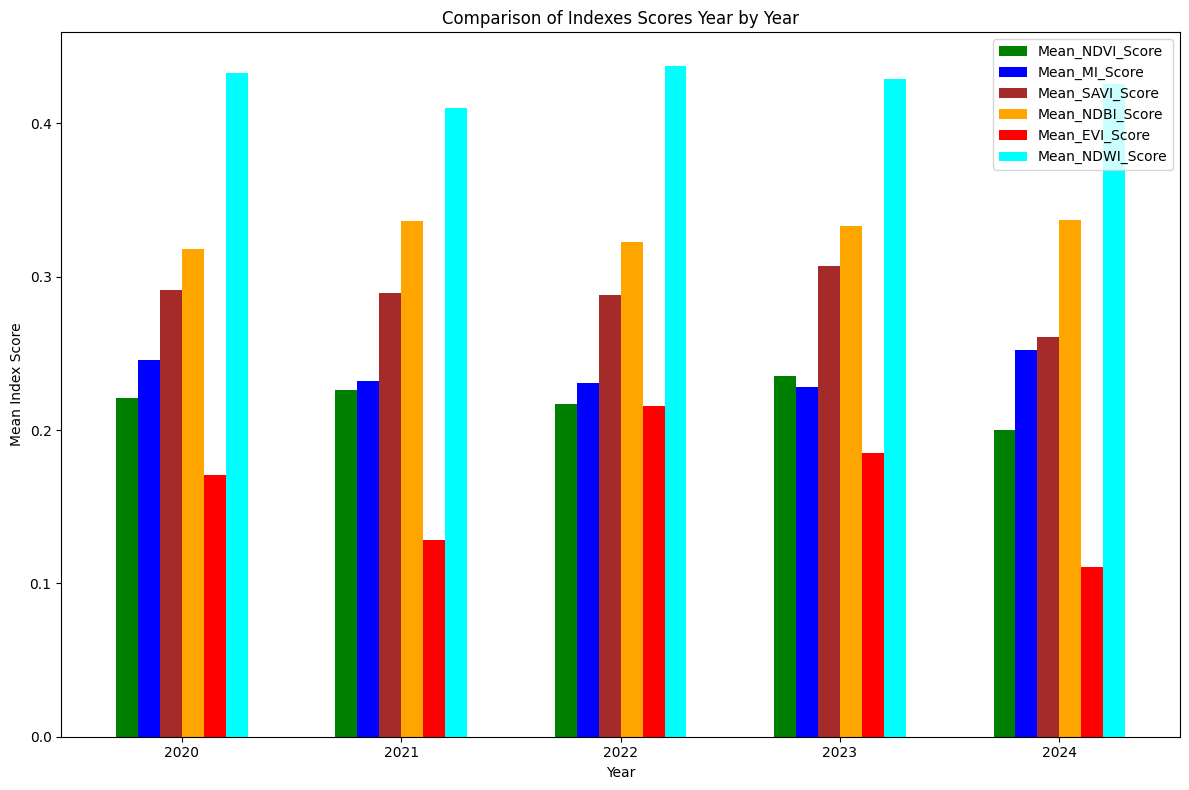

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the CSV into a DataFrame
df = pd.read_csv("/content/combined_scores_with_health_status.csv")

# Extract the year from 'Year_Month' column
df['Year'] = df['Year_Month'].apply(lambda x: x.split('_')[0])

# Calculate the mean score for each index by year
index_columns = [f'Mean_{index}_Score' for index in ['NDVI', 'MI', 'SAVI', 'NDBI', 'EVI', 'NDWI']]
yearly_scores = df.groupby('Year')[index_columns].mean()

# Plot the bar chart with legend and custom colors
fig, ax = plt.subplots(figsize=(12, 8))  # Adjust figure size
yearly_scores.plot(kind='bar', ax=ax, width=0.6, legend=True,
                   color=['green', 'blue', 'brown', 'orange', 'red', 'cyan'])  # Add colors

# Set labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Mean Index Score')
ax.set_title('Comparison of Indexes Scores Year by Year')

# Show the plot
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

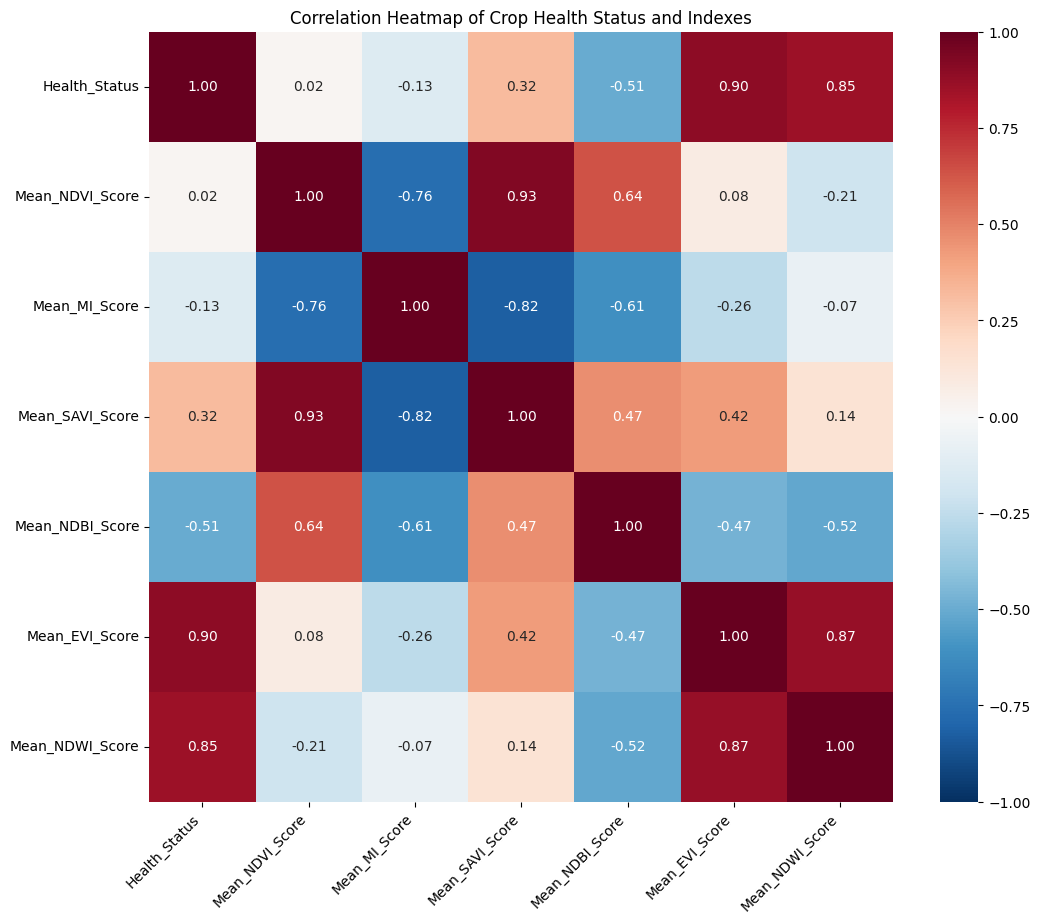

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Load the CSV into a DataFrame
df = pd.read_csv("/content/combined_scores_with_health_status.csv")

# Encode 'Crop_Health_Status' as numeric values
health_status_map = {'Bad': 0, 'Moderate': 1, 'Good': 2}
df['Health_Status'] = df['Crop_Health_Status'].map(health_status_map)

# Select relevant columns (index scores + health status)
columns_of_interest = ['Health_Status'] + [f'Mean_{index}_Score' for index in ['NDVI', 'MI', 'SAVI', 'NDBI', 'EVI', 'NDWI']]

# Create the correlation matrix
corr_matrix = df[columns_of_interest].corr()

# Plot the heatmap with improved color palette and annotation size
plt.figure(figsize=(12, 10))  # Adjust figure size if needed
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', fmt='.2f',
            vmin=-1, vmax=1, annot_kws={"size": 10})  # Adjust annotation size
plt.title("Correlation Heatmap of Crop Health Status and Indexes")
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import joblib


df_scores = pd.read_csv('combined_scores_with_health_status.csv',header=0)
status_map = {"Good":"1","Bad":"0"}
df_scores["Crop_Health_Status"] = df_scores["Crop_Health_Status"].map(status_map)

X=df_scores[["Mean_NDVI_Score","Mean_MI_Score","Mean_SAVI_Score","Mean_NDBI_Score","Mean_EVI_Score","Mean_NDWI_Score"]]
Y=df_scores["Crop_Health_Status"]

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3,random_state=42)

model=RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train,Y_train)

Y_pred=model.predict(X_test)
accuracy=accuracy_score(Y_test,Y_pred)
print(f"Accuracy:{accuracy}")

joblib.dump(model, 'crop_health_model.pkl')
print("Model saved as crop_health_model.pkl")

model = joblib.load('crop_health_model.pkl')


Accuracy:1.0
Model saved as crop_health_model.pkl


In [37]:
from pyngrok import ngrok
import os

# Set the ngrok authtoken (You can use the same token for multiple tunnels)
ngrok.set_auth_token("2sZTYaN9GHnuGBRxmFVwOg6WfqC_3A43BoyNmGjDcVB8QpATu")

# Set up two tunnels, each for a different Streamlit app on separate ports
public_url_1 = ngrok.connect(8501)  # Tunnel for the first app on port 8501
public_url_2 = ngrok.connect(8502)  # Tunnel for the second app on port 8502

print(f"First Streamlit app is live at {public_url_1}")
print(f"Second Streamlit app is live at {public_url_2}")

# Run the Streamlit apps on different ports
os.system("streamlit run crop_indexes_app.py --server.port 8501 &")
os.system("streamlit run crop_model_app.py --server.port 8502 &")


First Streamlit app is live at NgrokTunnel: "https://4b9a-35-230-65-120.ngrok-free.app" -> "http://localhost:8501"
Second Streamlit app is live at NgrokTunnel: "https://b653-35-230-65-120.ngrok-free.app" -> "http://localhost:8502"


0

In [36]:
!pkill ngrok